In [25]:
import pandas as pd

# Part 1 : Build DataFrame from WIKI

### Import Data from WIKI

In [38]:
link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
tables = pd.read_html(link,header=0)[0]
tables.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


### Drop borough == Not Assigned

In [39]:
tables = tables[tables['Borough'] != 'Not assigned']

In [40]:
print('original postal code',tables['Postal code'].shape)
print('unique postal code',tables['Postal code'].unique().shape)
print('No duplicate of Postal Code')

original postal code (103,)
unique postal code (103,)
No duplicate of Postal Code


## Check Neighborhood

In [41]:
for i in tables['Neighborhood'].unique() :
    print(i)

Parkwoods
Victoria Village
Regent Park / Harbourfront
Lawrence Manor / Lawrence Heights
Queen's Park / Ontario Provincial Government
Islington Avenue
Malvern / Rouge
Don Mills
Parkview Hill / Woodbine Gardens
Garden District / Ryerson
Glencairn
West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale
Rouge Hill / Port Union / Highland Creek
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood
Guildwood / Morningside / West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor / Wilson Heights / Downsview North
Thorncliffe Park
Richmond / Adelaide / King
Dufferin / Dovercourt Village
Scarborough Village
Fairview / Henry Farm / Oriole
Northwood Park / York University
East Toronto
Harbourfront East / Union Station / Toronto Islands
Little Portugal / Trinity
Kennedy Park / Ionview / East Birchmount Park
Bayview Village
Downsview
T

### Found that spliter of Neighborhood is "/" instead of ","

So, Replace / with ,

In [42]:
tables['Neighborhood'] = tables['Neighborhood'].str.replace(' /',',')
for i in tables['Neighborhood'].unique() :
    print(i)

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Riverdale
To

### Cleaning Columns and Print Row of Table

In [43]:
tables.columns = ['PostalCode','Borough','Neighborhood']
tables = tables.reset_index(drop = True)
print('Total Row is',tables.shape[0])

Total Row is 103




# Part 2 : Mapping Lat Long

### Import csv from  link

In [44]:
geo_table = pd.read_csv('https://cocl.us/Geospatial_data')

### See columns' name

In [46]:
tables.columns

Index(['PostalCode', 'Borough', 'Neighborhood'], dtype='object')

In [45]:
geo_table.columns

Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object')

### Merge 

In [119]:
df = pd.merge(tables,geo_table,left_on = 'PostalCode',right_on = 'Postal Code',how = 'left').drop('Postal Code',axis =1)
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# Part 3 : Analysis

In [130]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Find best k

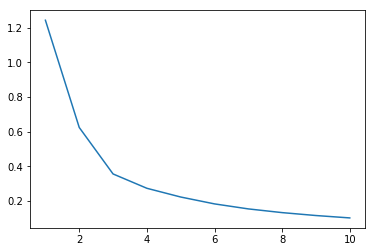

In [131]:
inertia = []
range_k = [1,2,3,4,5,6,7,8,9,10]
for i in range_k :
    model = KMeans(n_clusters = i)
    model.fit(df[['Latitude','Longitude']])
    inertia.append(model.inertia_)
    
plt.plot(range_k,inertia)
plt.show()

### Use K = 4

In [152]:
i = 4
model = KMeans(n_clusters = i)

df_result = df.copy()
df_result['cluster'] = model.fit_predict(df[['Latitude','Longitude']])
df_result.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,cluster
0,M3A,North York,Parkwoods,43.753259,-79.329656,3
1,M4A,North York,Victoria Village,43.725882,-79.315572,3
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,4
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0


### Plot the Map

In [153]:
import folium

In [154]:
df_result['cluster'].unique()
df_result['Latitude'].mean()

43.70460773398059

In [161]:
m = folium.Map(location=[df_result['Latitude'].mean(), df_result['Longitude'].mean()], zoom_start=11)

coler_dict = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red',4 : 'black'}
for i in df_result.index:
    folium.CircleMarker(
        [df_result.loc[i,'Latitude'], df_result.loc[i,'Longitude']],
        radius= 7,
        #popup = ('City: ' + str(city).capitalize() + '<br>'
        #         'Bike score: ' + str(bike) + '<br>'
        #         'Traffic level: ' + str(traffic) +'%'
        #        ),
        color='b',
        key_on = df_result.loc[i,'PostalCode'],
        #threshold_scale=[0,1,2,3],
        fill_color=coler_dict[df_result.loc[i,'cluster']],
        fill=True,
        fill_opacity=0.7
        ).add_to(m)
m


# Not Use just for fun

In [156]:
NB_set = df['Neighborhood'].str.replace(' ','').str.upper()
NB_set = NB_set.str.split(',',expand = True)
new_ab = pd.Series()
for i in NB_set.columns:
    new_ab = new_ab.append(NB_set[i])

new_ab = pd.DataFrame(new_ab).groupby(0).count().reset_index()
df_cluster = df.copy()
for i in new_ab[0]:
    df_cluster[i] = df_cluster['Neighborhood'].str.replace(' ','').str.upper().str.contains(i)*1

cluster_col = df_cluster.drop(['PostalCode', 'Borough', 'Neighborhood'],axis =1).columns
df_cluster.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ADELAIDE,AGINCOURT,AGINCOURTNORTH,ALBIONGARDENS,ALDERWOOD,...,WEXFORDHEIGHTS,WILLOWDALE,WILSONHEIGHTS,WOBURN,WOODBINEGARDENS,WOODBINEHEIGHTS,YORKMILLS,YORKMILLSWEST,YORKUNIVERSITY,YORKVILLE
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
